In [1]:
import numpy as np
from numpy.fft import rfft, rfftfreq
from scipy.sparse import spdiags
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import AnchoredText
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees,degrees2kilometers
import time
import scipy
from scipy import interpolate
import math
import glob
import os
import obspy

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import sys
sys.path.append('/home/yaolinm/Projects/Mexico2/')
from funcs.bp import *
from funcs.mccc import *
from funcs.utils import *

import imageio
import pandas as pd

from numba import njit
import numba
import copy

In [5]:
eq=earthquake(-103.269,18.2377,25.5)
sub1=earthquake(-103.55,18.55,25.5)
sub2=earthquake(-104,18.85,25.5)
sub3=earthquake(-104.4,19.15,25.5)
longitude_range=[-104.5,-102.5]
latitude_range=[17.5,19.5]
grid=gridize(longitude_range,latitude_range,stepsize=0.02)
x_mesh,y_mesh=grid.mesh()

mat=scipy.io.loadmat('/nfs/turbo/lsa-zspica/work/yaolinm/working_notebooks/mexico/my_bp_routine/posfib.mat')
channel_longs=mat['x0'][0]
channel_latis=mat['y0'][0]
selected_chs=np.load('/nfs/turbo/lsa-zspica/work/yaolinm/working_notebooks/mexico/my_bp_routine/egf1_s_selected_chs.npy')

das_latitudes,das_longitudes=[],[]
for i in range(0,len(selected_chs),20):
    das_latitudes.append(channel_latis[i])
    das_longitudes.append(channel_longs[i])

In [6]:
das_rtable=reference_table(model='iasp91',eq=eq,wave='P')       

corners=[[latitude_range[0],longitude_range[0]],[latitude_range[0],longitude_range[1]],[latitude_range[1],longitude_range[0]],[latitude_range[1],longitude_range[1]]]
degrees=[]
for corner in corners:
    for i in range(len(das_latitudes)):
        degrees.append(locations2degrees(das_latitudes[i],das_longitudes[i],corner[0],corner[1]))
        
das_rtable.cal_table(np.min(degrees)-0.1,np.max(degrees)+0.1,0.01)

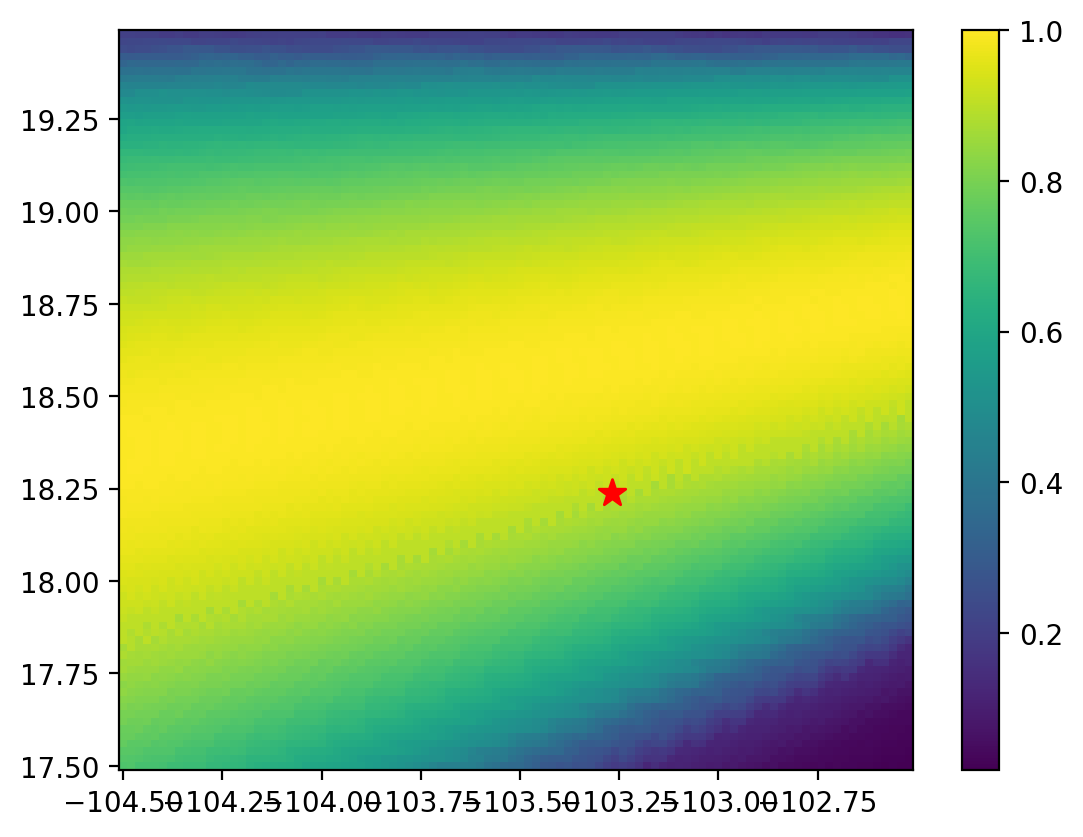

In [7]:
das_sensors=[]    
for i in range(len(das_latitudes)):
    das_sensor=sensor(das_longitudes[i],das_latitudes[i],trace_len=3000,sampling=50,eq_start=20)
    das_sensor.cal_epitime(eq,das_rtable)
    das_sensor.cal_epitime(sub1,das_rtable,etype='subevent')
#     das_sensor.cal_epitime(sub2,das_rtable,etype='subevent')
#     das_sensor.cal_epitime(sub3,das_rtable,etype='subevent')
    das_sensor.calculate_ttime(grid,das_rtable)
    tr=ricker_taup(60,das_sensor.sampling,1,1,20+1+das_sensor.subevents[0]-das_sensor.epitime)[0]
#     tr+=ricker_taup(120,das_sensor.sampling,0.1,0.8,20+8+das_sensor.subevents[1]-das_sensor.epitime)[0]
#     tr+=ricker_taup(120,das_sensor.sampling,0.1,0.6,20+20+das_sensor.subevents[2]-das_sensor.epitime)[0]
    das_sensor.trace=tr
    
    das_sensors.append(das_sensor)
    
bp_das=bp_bmfm(das_sensors,das_rtable,grid,eq)
bp_das.run_bp()
bp_das.plot_bp()

# reference window

In [8]:
from spectrum import dpss
def CMTM(X, Nw, freq_band=None, fsamp=None, scale=True):

    # Number of tapers
    K = 2 * Nw

    # Number of stations (m), time sampling points (Nx)
    m, Nf = X.shape

    # Next power of 2 (for FFT)
    # NFFT = 2**int(np.log2(Nf))
    NFFT = 2**int(np.log2(Nf) + 1) + 1

    # Subtract mean (over time axis) for each station
    X_mean = np.mean(X, axis=1)
    X_mean = np.tile(X_mean, [Nf, 1]).T
    X = X - X_mean

    # Compute taper weight coefficients
    tapers, eigenvalues = dpss(N=Nf, NW=Nw, k=K)

    # Compute weights from eigenvalues
    weights = eigenvalues / (np.arange(K) + 1).astype(float)

    # Align tapers with X
    tapers = np.tile(tapers.T, [m, 1, 1])
    tapers = np.swapaxes(tapers, 0, 1)

    # Compute tapered FFT of X
    # Note that X is assumed to be real, so that the negative frequencies can be discarded
    Xf = rfft(np.multiply(tapers, X), 2 * NFFT, axis=-1)

    # Multitaper power spectrum (not scaled by weights.sum()!)
    Pk = np.abs(Xf)**2
    Pxx = np.sum(Pk.T * weights, axis=-1).T
    inv_Px = 1 / np.sqrt(Pxx)

    inv_sum_weights = 1.0 / weights.sum()

    # If a specific frequency band is given
    if freq_band is not None:
        # Check if the sampling frequency is specified
        if fsamp is None:
            print("When a frequency band is selected, fsamp must be provided")
            return False
        # Compute the frequency range
        freqs = rfftfreq(n=2 * NFFT, d=1.0 / fsamp)
        # Select the frequency band indices
        inds = (freqs >= freq_band[0]) & (freqs < freq_band[1])
        # Slice the vectors
        Xf = Xf[:, :, inds]
        inv_Px = inv_Px[:, inds]

    Cxy = np.zeros((m, m, Xf.shape[2]), dtype=complex)

    # Loop over all stations
    for i in range(m):
        # Do only lower triangle
        for j in range(i):
            # Compute SUM[w_k . X_k . Y*_k] using Einstein notation
            Pxy = np.einsum("k,kt,kt->t", weights, Xf[:, i], Xf[:, j].conj(), optimize=True)
            # Store result in covariance matrix
            if scale:
                Cxy[i, j] = Pxy * (inv_Px[i] * inv_Px[j])
            else:
                Cxy[i, j] = Pxy * inv_sum_weights / Xf.shape[2]
        if not scale:
            Cxy[i, i] = 0.5 * np.einsum("k,kt,kt->t", weights, Xf[:, i], Xf[:, i].conj(), optimize=True) * inv_sum_weights / Xf.shape[2]
    # Make Cxy Hermitian
    Cxy = Cxy + np.transpose(Cxy.conj(), axes=[1, 0, 2])
    # Add ones to diagonal
    if scale:
        Cxy = Cxy + np.tile(np.eye(m), [Cxy.shape[2], 1, 1]).T
    return Cxy

In [9]:
longitude_grids,latitude_grids=grid.longitude_grids,grid.latitude_grids
dt=np.zeros((len(das_sensors)//2,len(longitude_grids)*len(latitude_grids)))
    
sampling_rate=50
frequency_band=[0.3,1]
winlen=3
winstep=1
starting_point=1.5*sampling_rate+5*sampling_rate
data=np.empty((len(das_sensors)//2,len(das_sensors[0].trace)))
for i in range(len(data)):
    data[i,:]=das_sensors[i*2].trace
    dt[i,:]=(das_sensors[i*2].arrival_mat-das_sensors[i*2].epitime).reshape(len(longitude_grids)*len(latitude_grids))
    
xsection=np.zeros((50,x_mesh.shape[0],x_mesh.shape[1]))
xsection_music=np.zeros((50,x_mesh.shape[0],x_mesh.shape[1]))

for i in range(50):
    
    starting_pt=int(starting_point+i*winstep*sampling_rate-winlen*sampling_rate/2)
    ending_pt=starting_pt+winlen*sampling_rate
    print(i,starting_pt,ending_pt)
    
    Cxy=CMTM(data[:,starting_pt:ending_pt],2,frequency_band,sampling_rate,scale=False)
    nfft=2**int(np.log2(winlen*sampling_rate) + 1) + 1
    freqs = rfftfreq(n=2 * nfft, d=1/sampling_rate)
    inds = (freqs >= frequency_band[0]) & (freqs < frequency_band[1])
    freqs=freqs[inds]
    
    Pconv=np.zeros((len(longitude_grids)*len(latitude_grids)),dtype='complex')

    for f in range(len(freqs)):

        steering=np.exp(-2j*np.pi*freqs[f]*dt)
        Un=Cxy[:,:,f].astype('complex')

        Pconv += np.einsum('sn, nk, sk->s', steering.conj().T,Un,steering.T,optimize=True)

    xsection[i,:,:]=Pconv.reshape(len(longitude_grids),len(latitude_grids)).real/(len(data)*len(freqs))
    
    Pmusic=np.zeros((len(longitude_grids)*len(latitude_grids)),dtype='complex')

    for f in range(len(freqs)):

        steering=np.exp(-2j*np.pi*freqs[f]*dt)
        Un=Cxy[:,:,f].astype('complex')
        l, v = np.linalg.eigh(Un)
        v=v[:,:-2]

        Pmusic += np.einsum('sn, nk, sk->s', steering.conj().T,np.dot(v,v.conj().T),steering.T,optimize=True)

    xsection_music[i,:,:]=1/(Pmusic.reshape(len(longitude_grids),len(latitude_grids)).real/(len(data)*len(freqs)))

0 250 400


/tmp/ipykernel_1189599/492655732.py:36: RuntimeWarning: divide by zero encountered in divide
  inv_Px = 1 / np.sqrt(Pxx)


1 300 450
2 350 500
3 400 550
4 450 600
5 500 650
6 550 700
7 600 750
8 650 800
9 700 850
10 750 900
11 800 950
12 850 1000
13 900 1050
14 950 1100
15 1000 1150
16 1050 1200
17 1100 1250
18 1150 1300
19 1200 1350
20 1250 1400
21 1300 1450
22 1350 1500
23 1400 1550
24 1450 1600
25 1500 1650
26 1550 1700
27 1600 1750
28 1650 1800
29 1700 1850
30 1750 1900
31 1800 1950
32 1850 2000
33 1900 2050
34 1950 2100
35 2000 2150
36 2050 2200
37 2100 2250
38 2150 2300
39 2200 2350
40 2250 2400
41 2300 2450
42 2350 2500
43 2400 2550
44 2450 2600
45 2500 2650
46 2550 2700
47 2600 2750
48 2650 2800
49 2700 2850


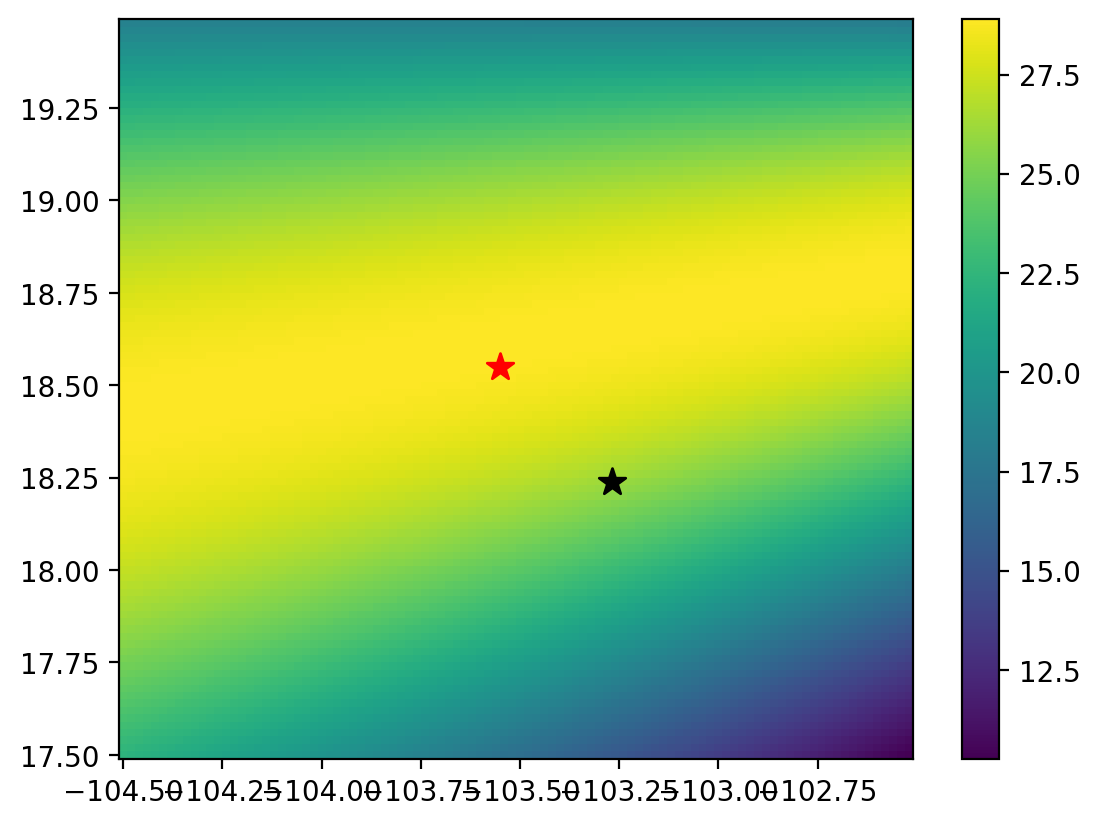

In [11]:
master=np.sum(xsection,axis=0)
fig=plt.figure(dpi=200)
pc=plt.pcolormesh(x_mesh,y_mesh,master.T)
plt.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=100)
plt.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=100)
plt.colorbar(pc)
plt.show()

# exact time

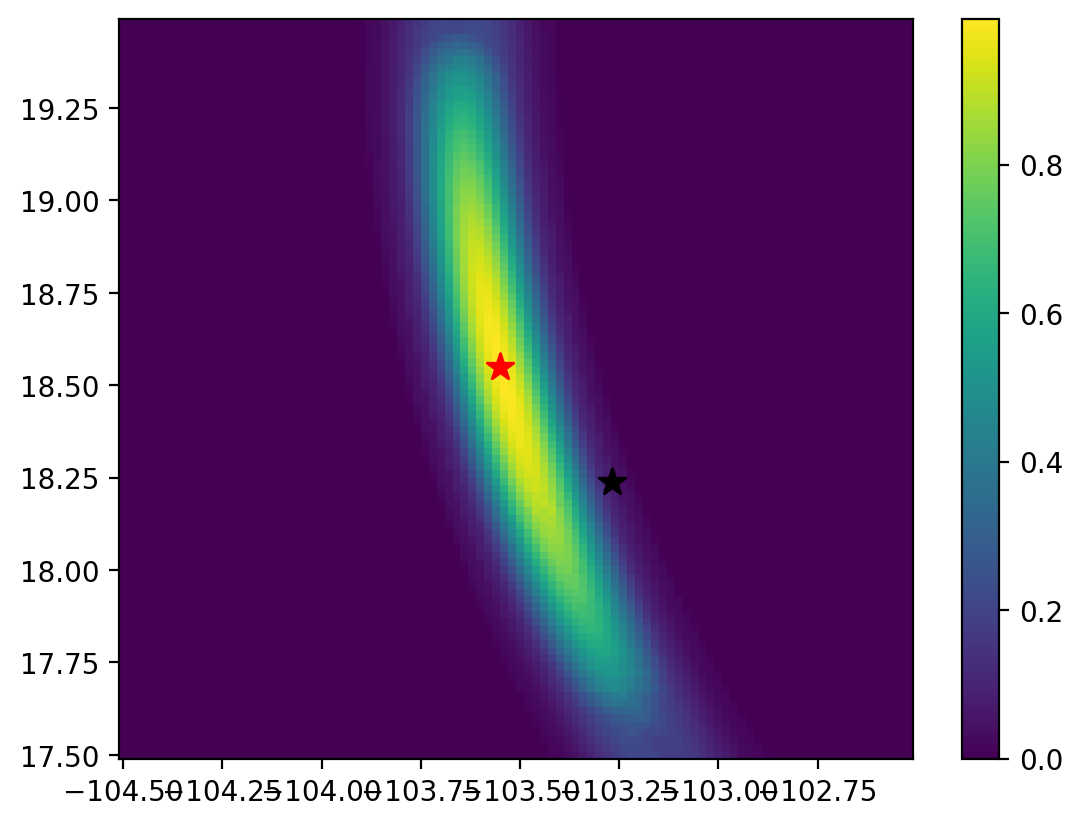

In [12]:
fig=plt.figure(dpi=200)
data=fetch_sliced_image(bp_das.master,17.5,5,time_window=5,temporal_averageing=5,sampling_rate=50,
                        normalize=False,taper='hamming')
pc=plt.pcolormesh(x_mesh,y_mesh,np.max(data,axis=-1).T)
plt.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=100)
plt.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=100)
plt.colorbar(pc)
plt.show()

# two phases

In [13]:
das_rtable_S=reference_table(model='iasp91',eq=eq,wave='S')       

corners=[[latitude_range[0],longitude_range[0]],[latitude_range[0],longitude_range[1]],[latitude_range[1],longitude_range[0]],[latitude_range[1],longitude_range[1]]]
degrees=[]
for corner in corners:
    for i in range(len(das_latitudes)):
        degrees.append(locations2degrees(das_latitudes[i],das_longitudes[i],corner[0],corner[1]))
        
das_rtable_S.cal_table(np.min(degrees)-0.1,np.max(degrees)+0.1,0.01)

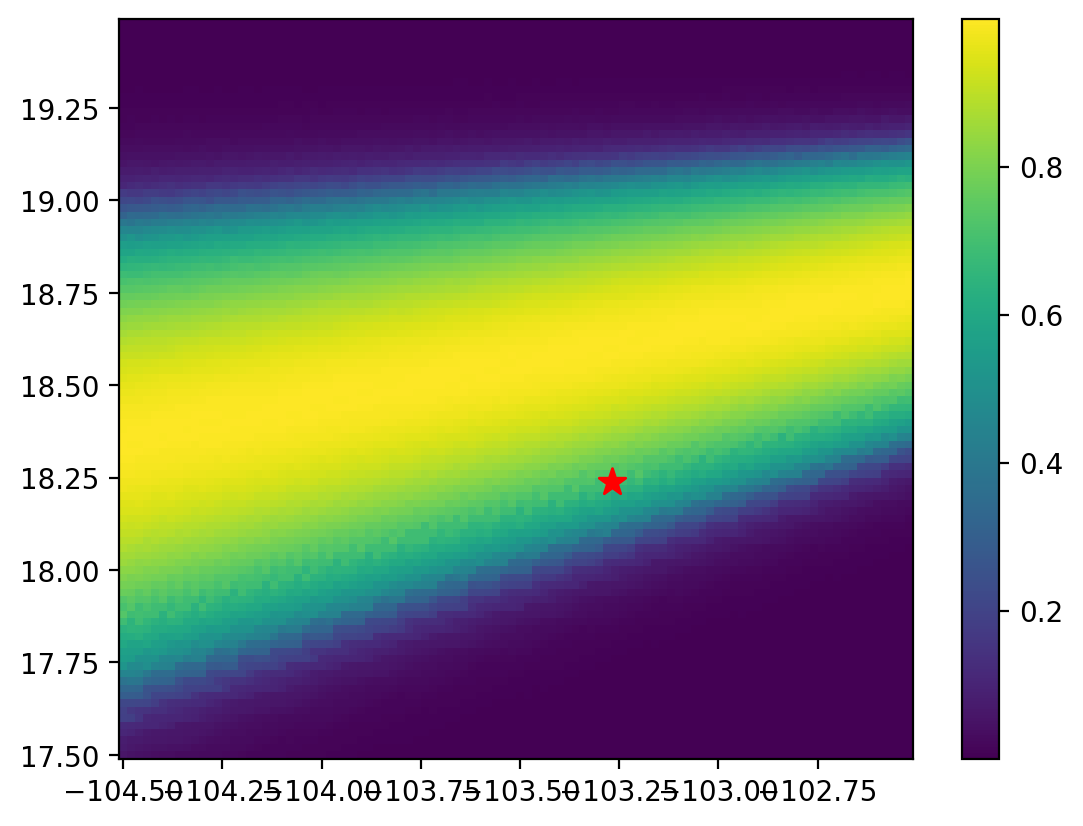

In [14]:
das_sensors_S=[]    
for i in range(len(das_latitudes)):
    das_sensor=sensor(das_longitudes[i],das_latitudes[i],trace_len=3000,sampling=50,eq_start=20)
    das_sensor.cal_epitime(eq,das_rtable_S)
    das_sensor.cal_epitime(sub1,das_rtable_S,etype='subevent')
    das_sensor.calculate_ttime(grid,das_rtable_S)
    tr=ricker_taup(60,das_sensor.sampling,1,1,20+1+das_sensor.subevents[0]-das_sensor.epitime)[0]
    das_sensor.trace=tr
    das_sensors_S.append(das_sensor)
    
bp_das_S=bp_bmfm(das_sensors_S,das_rtable_S,grid,eq)
bp_das_S.run_bp()
bp_das_S.plot_bp()

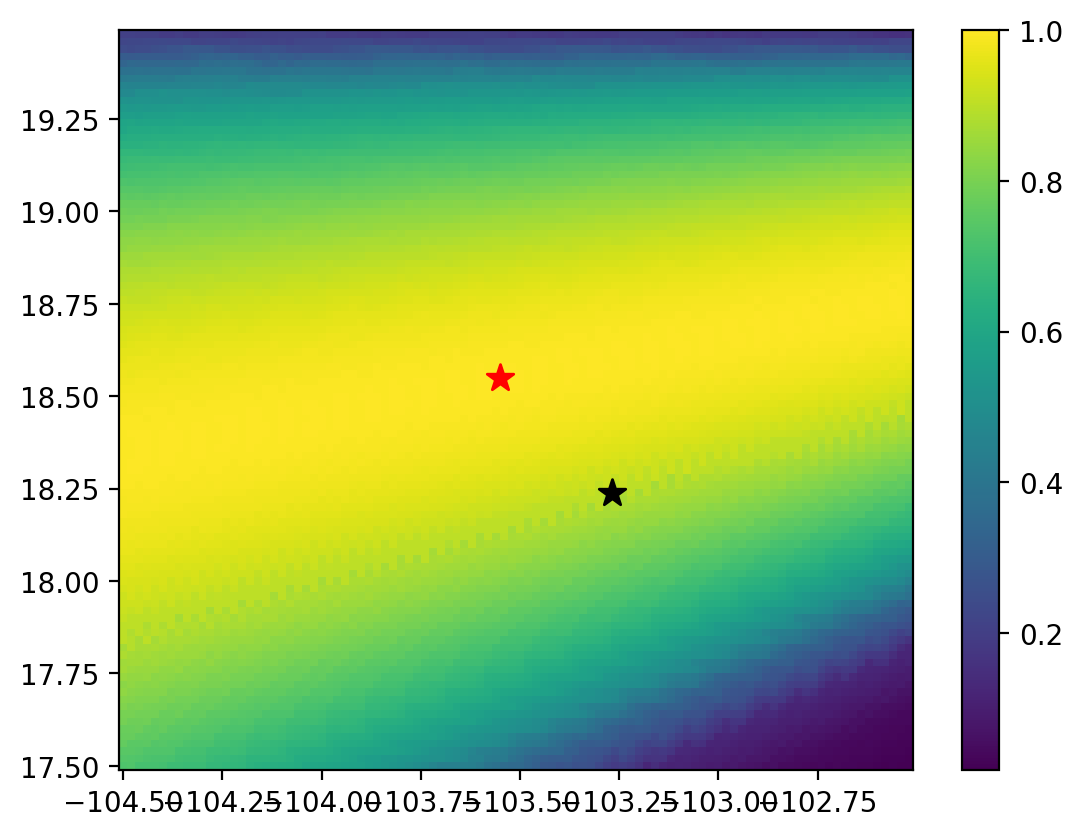

In [15]:
master=np.max(normalize(bp_das.master),axis=-1)
fig=plt.figure(dpi=200)
pc=plt.pcolormesh(x_mesh,y_mesh,master.T)
plt.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=100)
plt.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=100)
plt.colorbar(pc)
plt.show()

/tmp/ipykernel_1189599/1344836003.py:1: RuntimeWarning: overflow encountered in multiply
  master=np.max(normalize(bp_das_S.master)*normalize(bp_das.master),axis=-1)


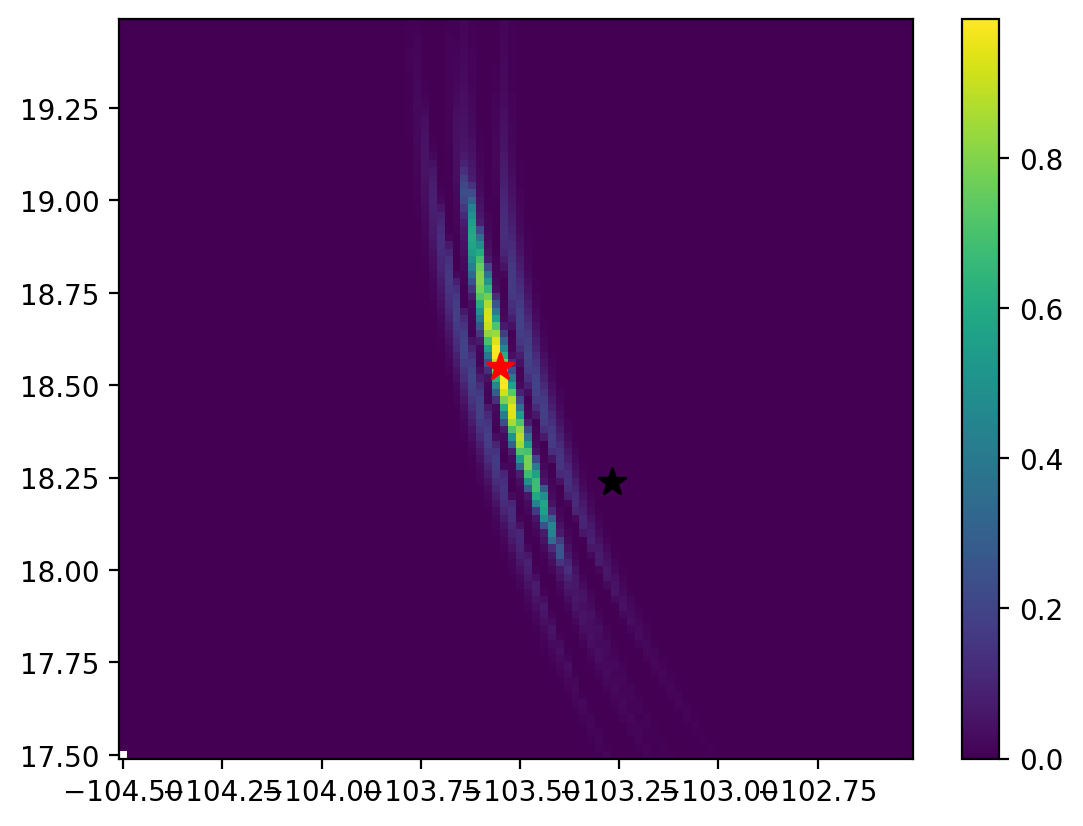

In [16]:
master=np.max(normalize(bp_das_S.master)*normalize(bp_das.master),axis=-1)
fig=plt.figure(dpi=200)
pc=plt.pcolormesh(x_mesh,y_mesh,master.T)
plt.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=100)
plt.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=100)
plt.colorbar(pc)
plt.show()

# additional array

In [17]:
from geopy.distance import geodesic
from geographiclib.geodesic import Geodesic

def calculate_distance_azimuth(coord1, coord2):
    distance = geodesic(coord1, coord2).km
    geod = Geodesic.WGS84
    azimuth = geod.Inverse(coord1[0], coord1[1], coord2[0], coord2[1])['azi1']

    return distance, azimuth

def calculate_destination(coord, distance, azimuth):
    geod = Geodesic.WGS84
    result = geod.Direct(coord[0], coord[1], azimuth, distance * 1000)  # Convert km to meters
    return result['lat2'], result['lon2']

for i in range(len(das_latitudes)):
    print(calculate_distance_azimuth((eq.latitude,eq.longitude),(das_latitudes[i],das_longitudes[i])))
    
new_latitudes,new_longitudes=[],[]
for azi in np.arange(-18,-15,0.1):
    destination = calculate_destination((eq.latitude,eq.longitude), 450, azi)
    print(destination)
    new_latitudes.append(destination[0])
    new_longitudes.append(destination[1])

(447.0064762936718, 73.77501599374297)
(447.0289801064834, 73.76383315846995)
(447.2282912827843, 73.7603935989807)
(447.4405122911117, 73.77765498936587)
(447.65228390318134, 73.79579859111335)
(447.8540816677679, 73.8040418825772)
(447.9654883396099, 73.77689845591277)
(448.14436985162746, 73.76225961305705)
(448.17194576094204, 73.77401121394577)
(448.24691962751274, 73.74974804993262)
(448.3331113547987, 73.7188977348553)
(448.37993379582247, 73.68679084543135)
(448.4051423341437, 73.65425081521938)
(448.2928943086749, 73.62653593443696)
(448.112357417396, 73.60442157716415)
(447.8954526495109, 73.58772425968769)
(447.74126518993006, 73.5617902879641)
(447.7980984464772, 73.531471210365)
(447.91257655606955, 73.5021342263812)
(448.0259359984967, 73.47272473670697)
(448.12546203040887, 73.44660250721037)
(448.1772919881705, 73.43290372661644)
(448.32247104802593, 73.40726918651652)
(448.5503278762685, 73.39251112122689)
(448.76227353704377, 73.37425616740528)
(448.9784670122484, 73.

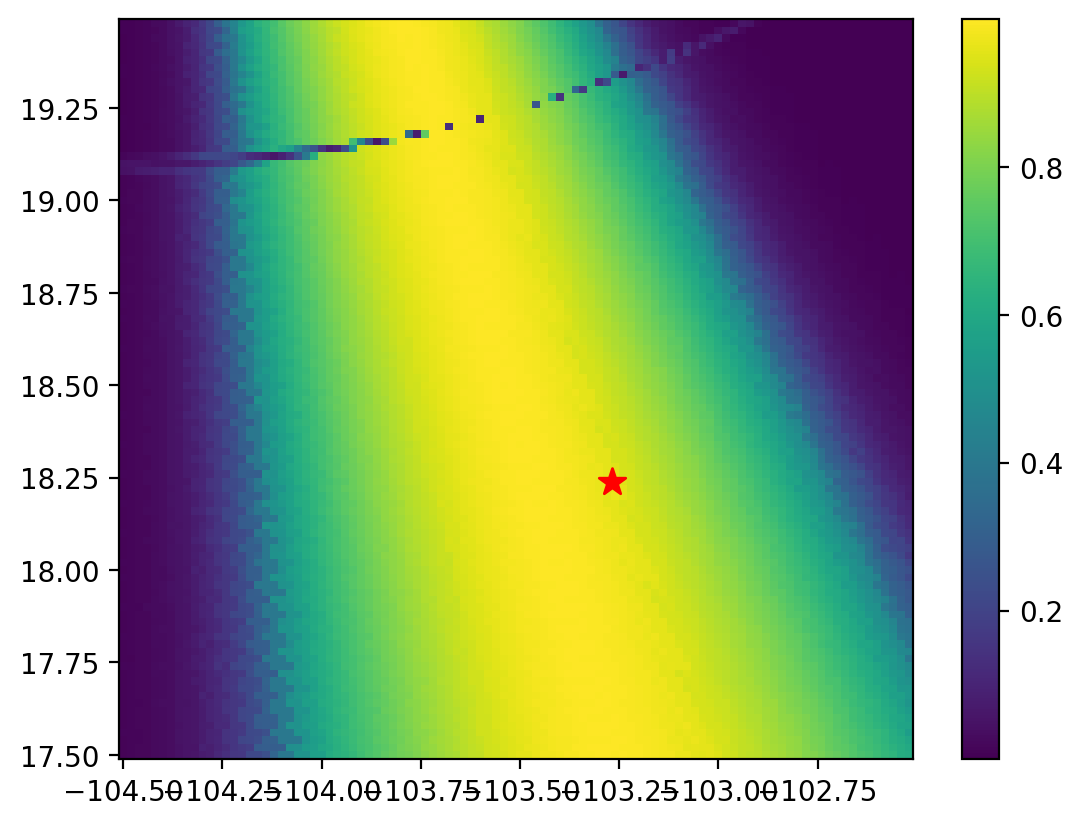

In [18]:
das_sensors2=[]    
for i in range(len(new_latitudes)):
    das_sensor=sensor(new_longitudes[i],new_latitudes[i],trace_len=3000,sampling=50,eq_start=20)
    das_sensor.cal_epitime(eq,das_rtable)
    das_sensor.cal_epitime(sub1,das_rtable,etype='subevent')
    das_sensor.calculate_ttime(grid,das_rtable)
    tr=ricker_taup(60,das_sensor.sampling,1,1,20+1+das_sensor.subevents[0]-das_sensor.epitime)[0]
    das_sensor.trace=tr
    
    das_sensors2.append(das_sensor)
    
bp_das2=bp_bmfm(das_sensors2,das_rtable,grid,eq)
bp_das2.run_bp()
bp_das2.plot_bp()

/tmp/ipykernel_1189599/2372029455.py:1: RuntimeWarning: overflow encountered in multiply
  master=np.max(normalize(bp_das2.master)*normalize(bp_das.master),axis=-1)


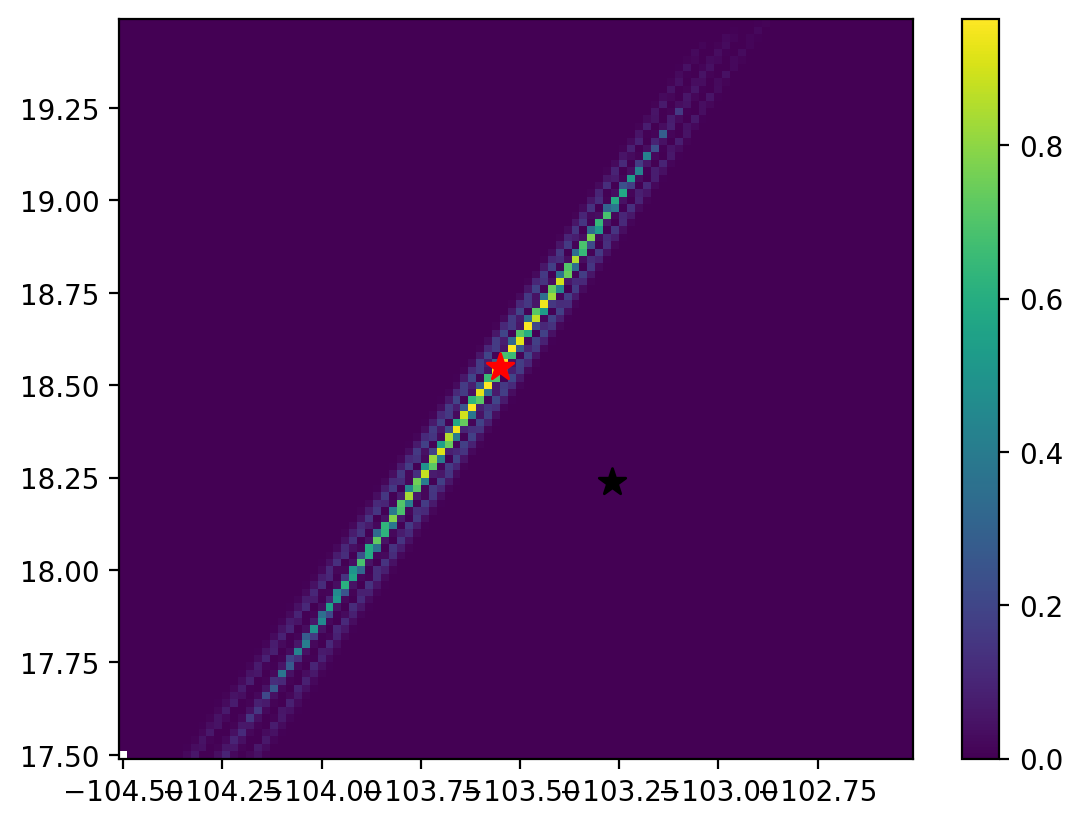

In [19]:
master=np.max(normalize(bp_das2.master)*normalize(bp_das.master),axis=-1)
fig=plt.figure(dpi=200)
pc=plt.pcolormesh(x_mesh,y_mesh,master.T)
plt.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=100)
plt.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=100)
plt.colorbar(pc)
plt.show()

# Plot

In [22]:
import netCDF4 as nc
import cmocean
file='/home/yaolinm/Projects/Mexico2/data/gebco_2024_n21.0_s16.0_w-106.0_e-101.0.nc'
dataset = nc.Dataset(file, 'r')
variable = dataset.variables['elevation']
bmap = variable[:] 

from scipy.ndimage import zoom
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm as cm
resized_x_mesh=zoom(x_mesh,zoom=4,order=1)
resized_y_mesh=zoom(y_mesh,zoom=4,order=1)

colors = ['white', 'lightgray', 'gray', 'dimgray']
bounds = [-4000, 0, 1, 2, 4000]  # Define boundaries between colors
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

In [39]:
resized_data=zoom(np.sum(xsection,axis=0).T,zoom=4,order=1)
np.min(resized_data)

10.267481745036871

/tmp/ipykernel_1189599/4212305694.py:31: RuntimeWarning: overflow encountered in multiply
  resized_data=zoom(np.max(normalize(bp_das_S.master)*normalize(bp_das.master),axis=-1).T,zoom=4,order=1)
/tmp/ipykernel_1189599/4212305694.py:39: RuntimeWarning: overflow encountered in multiply
  resized_data=zoom(np.max(normalize(bp_das2.master)*normalize(bp_das.master),axis=-1).T,zoom=4,order=1)


[Text(-104, 0, '-104°'), Text(-103, 0, '-103°')]

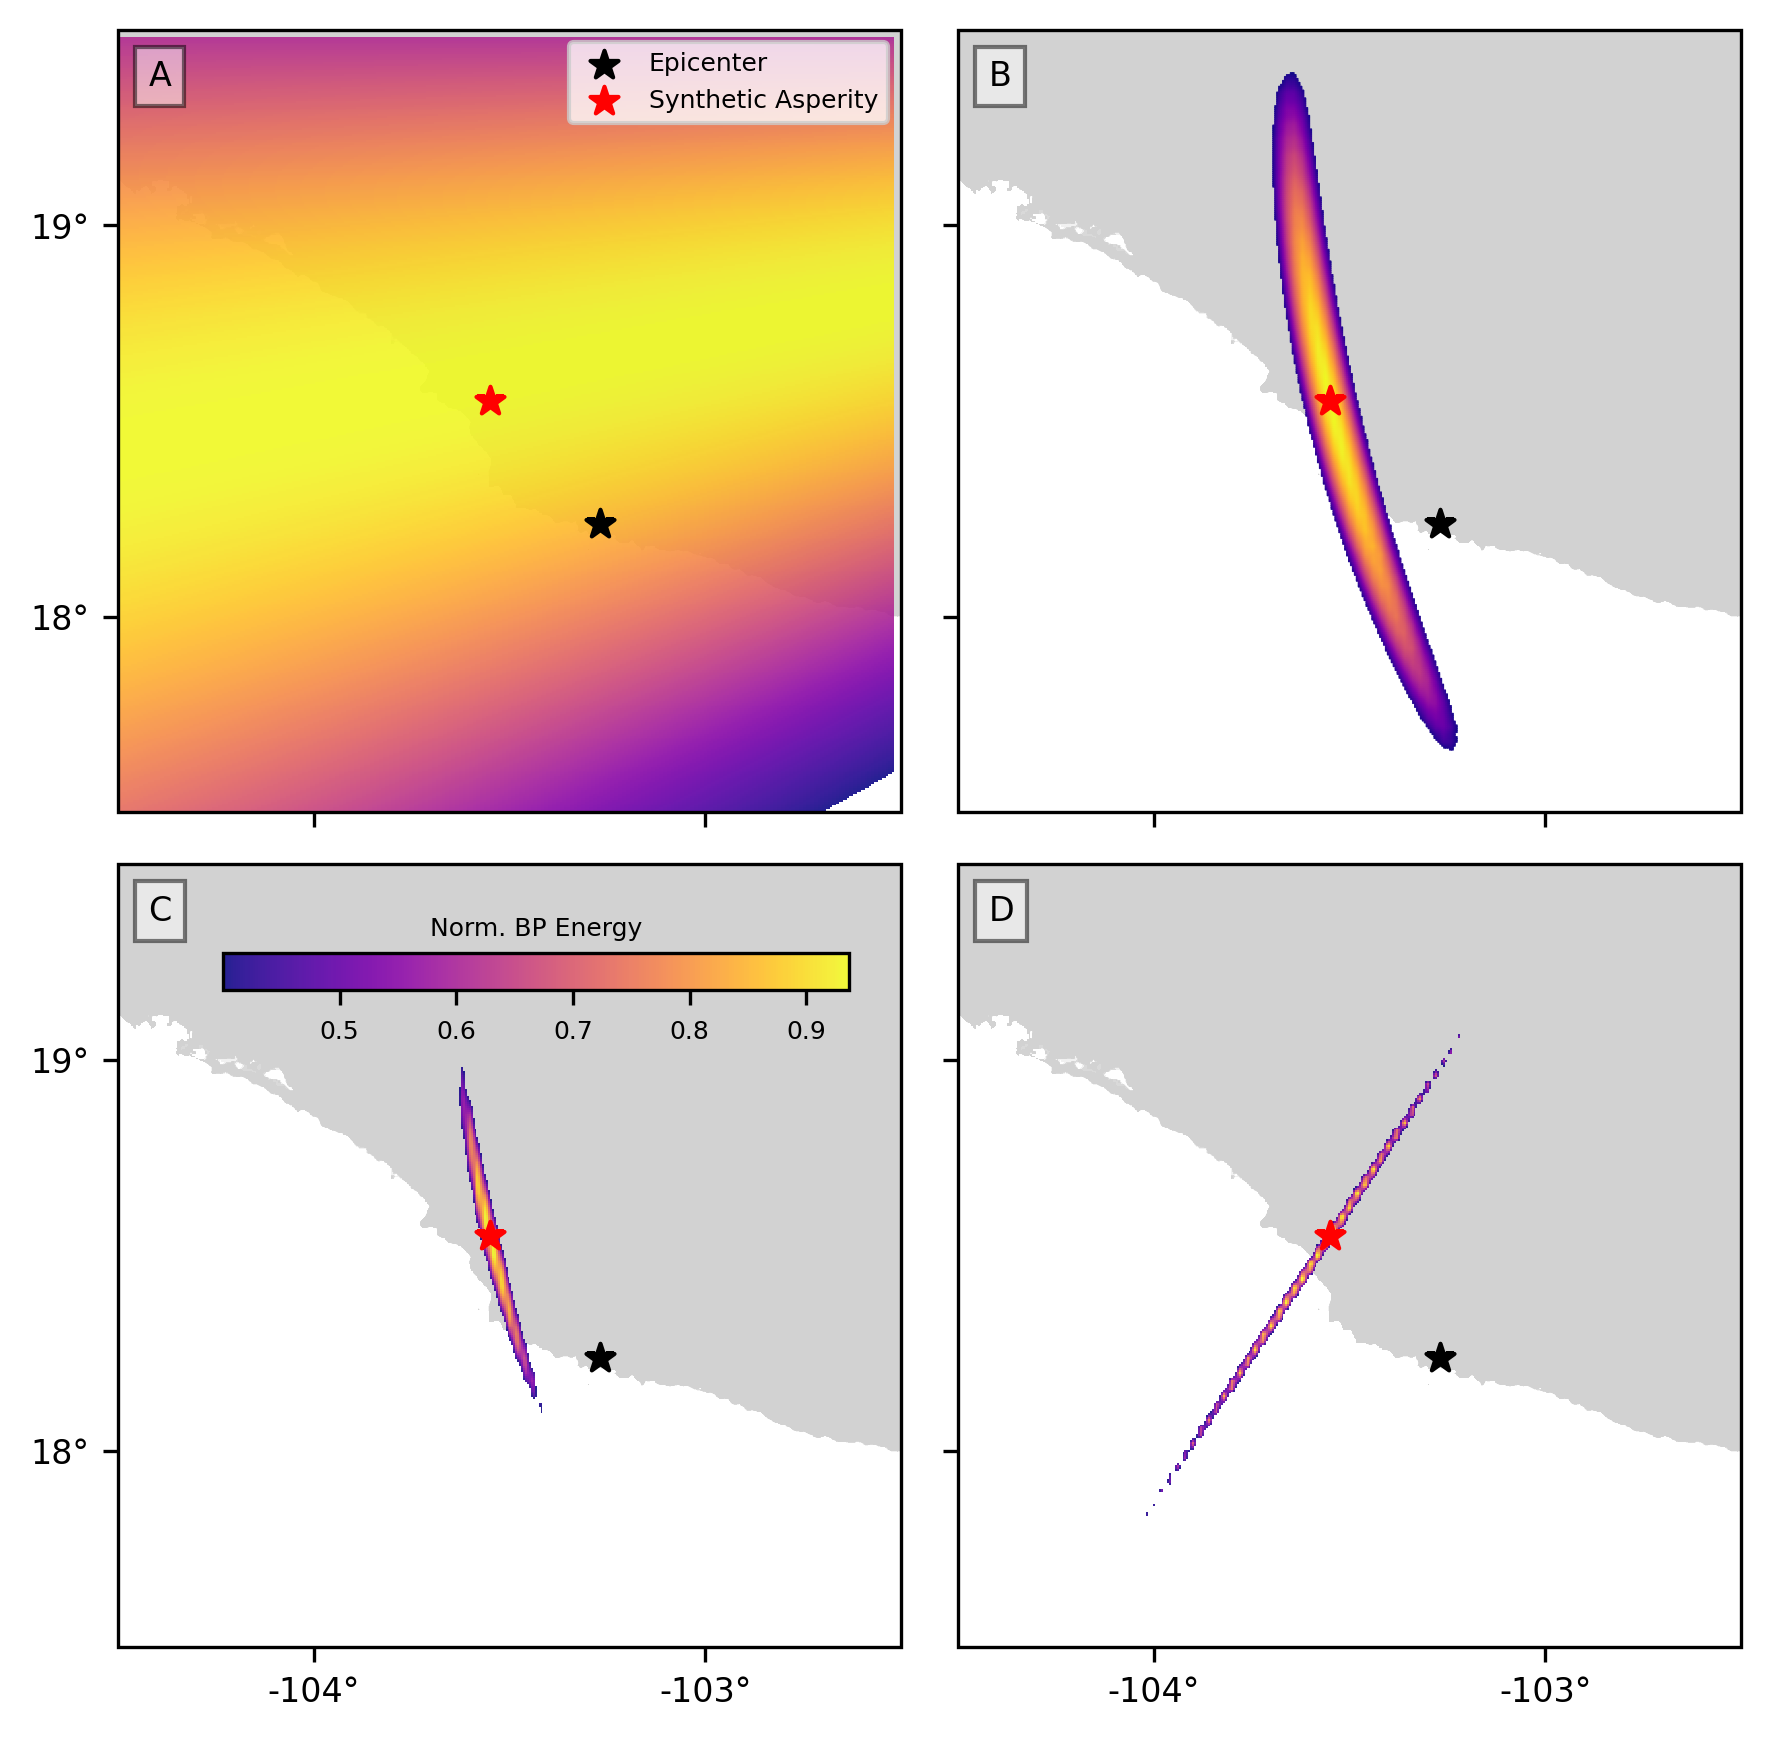

In [47]:
fig=plt.figure(dpi=300,figsize=(7,7))
fig.subplots_adjust(hspace=0.6,wspace=0.6)
proj=cartopy.crs.PlateCarree()

ax0 = plt.subplot2grid(shape=(12,12), loc=(0,0), colspan=6,rowspan=6, projection=proj)
ax1 = plt.subplot2grid(shape=(12,12), loc=(0,6), colspan=6,rowspan=6, projection=proj)
ax2 = plt.subplot2grid(shape=(12,12), loc=(6,0), colspan=6,rowspan=6, projection=proj)
ax3 = plt.subplot2grid(shape=(12,12), loc=(6,6), colspan=6,rowspan=6, projection=proj)

bs=ax0.imshow(np.flipud(bmap[240:960,240:960]),cmap=cmap,norm=norm,
              alpha=0.3,extent=[-105.02,-102,16.98,20],transform=proj)
resized_data=zoom(normalize(np.sum(xsection,axis=0).T),zoom=4,order=1)
z=np.ma.masked_array(resized_data,resized_data<0.4)
pc=ax0.pcolormesh(resized_x_mesh,resized_y_mesh,z,cmap='plasma',alpha=0.9)
ax0.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=50,label='Epicenter')
ax0.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=50,label='Synthetic Asperity')

ax1.imshow(np.flipud(bmap[240:960,240:960]),cmap=cmap,norm=norm,
              alpha=0.3,extent=[-105.02,-102,16.98,20],transform=proj)
data=fetch_sliced_image(bp_das.master,17.5,5,time_window=3,temporal_averageing=3,sampling_rate=50,
                        normalize=False,taper='hamming')
resized_data=zoom(normalize(np.max(data,axis=-1)).T,zoom=4,order=1)
z=np.ma.masked_array(resized_data,resized_data<0.4)
ax1.pcolormesh(resized_x_mesh,resized_y_mesh,z,cmap='plasma',alpha=0.9,shading='gouraud')
ax1.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=50,label='Epicenter')
ax1.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=50,label='Synthetic Asperity')


ax2.imshow(np.flipud(bmap[240:960,240:960]),cmap=cmap,norm=norm,
              alpha=0.3,extent=[-105.02,-102,16.98,20],transform=proj)
resized_data=zoom(np.max(normalize(bp_das_S.master)*normalize(bp_das.master),axis=-1).T,zoom=4,order=1)
z=np.ma.masked_array(resized_data,resized_data<0.4)
pc=ax2.pcolormesh(resized_x_mesh,resized_y_mesh,z,cmap='plasma',alpha=0.9)
ax2.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=50,label='Epicenter')
ax2.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=50,label='Synthetic Asperity')

ax3.imshow(np.flipud(bmap[240:960,240:960]),cmap=cmap,norm=norm,
              alpha=0.3,extent=[-105.02,-102,16.98,20],transform=proj)
resized_data=zoom(np.max(normalize(bp_das2.master)*normalize(bp_das.master),axis=-1).T,zoom=4,order=1)
z=np.ma.masked_array(resized_data,resized_data<0.4)
ax3.pcolormesh(resized_x_mesh,resized_y_mesh,z,cmap='plasma',alpha=0.9)
ax3.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=50,label='Epicenter')
ax3.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=50,label='Synthetic Asperity')

ax0.legend(loc='upper right', fontsize=6, frameon=True)

cax1 = fig.add_axes([ax2.get_position().x0+0.05, ax2.get_position().y1 - 0.06, 
                           ax3.get_position().width*0.8, 0.018])
cbar1 = plt.colorbar(pc, cax=cax1, orientation='horizontal')
cbar1.set_label('Norm. BP Energy', fontsize=6)
cbar1.ax.tick_params(labelsize=6)
cbar1.ax.xaxis.set_label_position("top")


# ax0.text(0.03, 0.96, 'A Reference Window BP', transform=ax0.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='left', 
#         bbox=dict(facecolor='white',edgecolor='grey',alpha=0.8,pad=0))
# ax1.text(0.03, 0.96, 'B BP with Exact Time', transform=ax1.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='left', 
#         bbox=dict(facecolor='white',edgecolor='grey',alpha=0.8,pad=0))
# ax2.text(0.03, 0.96, 'C P+S Wave BP', transform=ax2.transAxes, fontsize=8,verticalalignment='top', horizontalalignment='left', 
#         bbox=dict(facecolor='white',edgecolor='grey',alpha=0.8,pad=0))
# ax3.text(0.03, 0.96, 'D Multiarray BP', transform=ax3.transAxes, fontsize=8,verticalalignment='top', horizontalalignment='left', 
#         bbox=dict(facecolor='white',edgecolor='grey',alpha=0.8,pad=0))

# at = AnchoredText('A Reference Window BP',prop=dict(size=8), frameon=True,loc=2)
# at.patch.set_boxstyle('round',pad=0,rounding_size=0)
# at.patch.set_facecolor((1, 1, 1, 0.5))  
# at.patch.set_edgecolor((0, 0, 0, 0.5))
# ax0.add_artist(at)

# at = AnchoredText('B BP with Exact Time',prop=dict(size=8), frameon=True,loc=2)
# at.patch.set_boxstyle('round',pad=0,rounding_size=0)
# at.patch.set_facecolor((1, 1, 1, 0.5))  
# at.patch.set_edgecolor((0, 0, 0, 0.5))
# ax1.add_artist(at)

# at = AnchoredText('C P+S Wave BP',prop=dict(size=8), frameon=True,loc=2)
# at.patch.set_boxstyle('round',pad=0,rounding_size=0)
# at.patch.set_facecolor((1, 1, 1, 0.5))  
# at.patch.set_edgecolor((0, 0, 0, 0.5))
# ax2.add_artist(at)

# at = AnchoredText('D Multiarray BP',prop=dict(size=8), frameon=True,loc=2)
# at.patch.set_boxstyle('round',pad=0,rounding_size=0)
# at.patch.set_facecolor((1, 1, 1, 0.5))  
# at.patch.set_edgecolor((0, 0, 0, 0.5))
# ax3.add_artist(at)

at = AnchoredText('A',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0)
at.patch.set_facecolor((1, 1, 1, 0.5))  
at.patch.set_edgecolor((0, 0, 0, 0.5))
ax0.add_artist(at)

at = AnchoredText('B',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0)
at.patch.set_facecolor((1, 1, 1, 0.5))  
at.patch.set_edgecolor((0, 0, 0, 0.5))
ax1.add_artist(at)

at = AnchoredText('C',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0)
at.patch.set_facecolor((1, 1, 1, 0.5))  
at.patch.set_edgecolor((0, 0, 0, 0.5))
ax2.add_artist(at)

at = AnchoredText('D',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0)
at.patch.set_facecolor((1, 1, 1, 0.5))  
at.patch.set_edgecolor((0, 0, 0, 0.5))
ax3.add_artist(at)

for ax in [ax0,ax1,ax2,ax3]:

    ax.set_xticks([-104, -103])
    ax.set_xticklabels( ['',''], fontsize=8)
    ax.set_yticks([18, 19])
    ax.set_yticklabels(['',''], fontsize=8)
    ax.set_xlim(-104.5,-102.5)
    ax.set_ylim(17.5,19.5)

ax0.set_yticks([18, 19])
ax0.set_yticklabels([f"{y}°" for y in [18, 19]], fontsize=8)
ax2.set_yticks([18, 19])
ax2.set_yticklabels([f"{y}°" for y in [18, 19]], fontsize=8)
ax2.set_xticks([-104, -103])
ax2.set_xticklabels([f"{x}°" for x in [-104, -103]], fontsize=8)
ax3.set_xticks([-104, -103])
ax3.set_xticklabels([f"{x}°" for x in [-104, -103]], fontsize=8)

# Animation

In [35]:
np.min(xsection)

0.0

In [48]:
normalized_xsection=normalize(xsection)

for index in range(50):
    
    fig=plt.figure(dpi=200,figsize=(7,7))
    fig.subplots_adjust(hspace=0.6,wspace=0.6)
    proj=cartopy.crs.PlateCarree()

    ax0 = plt.subplot2grid(shape=(12,12), loc=(0,0), colspan=6,rowspan=6, projection=proj)
    ax1 = plt.subplot2grid(shape=(12,12), loc=(0,6), colspan=6,rowspan=6, projection=proj)
    ax2 = plt.subplot2grid(shape=(12,12), loc=(6,0), colspan=6,rowspan=6, projection=proj)
    ax3 = plt.subplot2grid(shape=(12,12), loc=(6,6), colspan=6,rowspan=6, projection=proj)

    bs=ax0.imshow(np.flipud(bmap[240:960,240:960]),cmap=cmap,norm=norm,
                  alpha=0.3,extent=[-105.02,-102,16.98,20],transform=proj)
    resized_data=zoom(normalized_xsection[index,:,:].T,zoom=4,order=1)
    z=np.ma.masked_array(resized_data,resized_data<0.6)
    pc=ax0.pcolormesh(resized_x_mesh,resized_y_mesh,z,cmap='plasma',alpha=0.9,vmin=0.4,vmax=1)
    ax0.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=50,label='Epicenter')
    ax0.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=50,label='Synthetic Asperity')

    ax1.imshow(np.flipud(bmap[240:960,240:960]),cmap=cmap,norm=norm,
                  alpha=0.3,extent=[-105.02,-102,16.98,20],transform=proj)
    data=fetch_sliced_image(bp_das.master,index,5,time_window=3,temporal_averageing=3,sampling_rate=50,
                            normalize=False,taper='hamming')
    data=np.max(data,axis=-1)
    resized_data=zoom(data.T,zoom=4,order=1)
    z=np.ma.masked_array(resized_data,resized_data<0.4)
    ax1.pcolormesh(resized_x_mesh,resized_y_mesh,z,cmap='plasma',alpha=0.9,shading='gouraud')
    ax1.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=50,label='Epicenter')
    ax1.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=50,label='Synthetic Asperity')


    ax2.imshow(np.flipud(bmap[240:960,240:960]),cmap=cmap,norm=norm,
                  alpha=0.3,extent=[-105.02,-102,16.98,20],transform=proj)
    data=fetch_sliced_image(normalize(bp_das_S.master)*normalize(bp_das.master),index,5,time_window=3,temporal_averageing=3,sampling_rate=50,
                        normalize=False,taper='hamming')
    data=np.max(data,axis=-1)
    resized_data=zoom(data.T,zoom=4,order=1)
    z=np.ma.masked_array(resized_data,resized_data<0.4)
    ax2.pcolormesh(resized_x_mesh,resized_y_mesh,z,cmap='plasma',alpha=0.9)
    ax2.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=50,label='Epicenter')
    ax2.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=50,label='Synthetic Asperity')

    ax3.imshow(np.flipud(bmap[240:960,240:960]),cmap=cmap,norm=norm,
                  alpha=0.3,extent=[-105.02,-102,16.98,20],transform=proj)
    data=fetch_sliced_image(normalize(bp_das2.master)*normalize(bp_das.master),index,5,time_window=3,temporal_averageing=3,sampling_rate=50,
                    normalize=False,taper='hamming')
    data=np.max(data,axis=-1)
    resized_data=zoom(data.T,zoom=4,order=1)
    z=np.ma.masked_array(resized_data,resized_data<0.4)
    ax3.pcolormesh(resized_x_mesh,resized_y_mesh,z,cmap='plasma',alpha=0.9)
    ax3.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=50,label='Epicenter')
    ax3.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=50,label='Synthetic Asperity')

    ax0.legend(loc='upper right', fontsize=6, frameon=True)

    cax1 = fig.add_axes([ax2.get_position().x0+0.05, ax2.get_position().y1 - 0.07, 
                               ax3.get_position().width*0.8, 0.018])
    cbar1 = plt.colorbar(pc, cax=cax1, orientation='horizontal')
    cbar1.set_label('Norm. BP Energy', fontsize=6)
    cbar1.ax.tick_params(labelsize=6)
    cbar1.ax.xaxis.set_label_position("top")

    ax0.text(0.03, 0.96, '[A] Reference Window BP', transform=ax0.transAxes, fontsize=6, verticalalignment='top', horizontalalignment='left', 
            bbox=dict(facecolor='white',edgecolor='grey',alpha=0.8,pad=1))
    ax1.text(0.03, 0.96, '[B] S Wave Conventional BP', transform=ax1.transAxes, fontsize=6, verticalalignment='top', horizontalalignment='left', 
            bbox=dict(facecolor='white',edgecolor='grey',alpha=0.8,pad=1))
    ax2.text(0.03, 0.96, '[C] P+S Wave BP', transform=ax2.transAxes, fontsize=6,verticalalignment='top', horizontalalignment='left', 
            bbox=dict(facecolor='white',edgecolor='grey',alpha=0.8,pad=1))
    ax3.text(0.03, 0.96, '[D] Multiarray BP', transform=ax3.transAxes, fontsize=6,verticalalignment='top', horizontalalignment='left', 
            bbox=dict(facecolor='white',edgecolor='grey',alpha=0.8,pad=1))


    for ax in [ax0,ax1,ax2,ax3]:
        ax.set_yticks([18, 19,])
        ax.set_yticklabels(['',''])
        ax.set_xticks([-104, -103])
        ax.set_xticklabels(['',''])
        ax.set_xlim(-104.5,-102.5)
        ax.set_ylim(17.5,19.5)
        
    ax0.set_yticks([18, 19])
    ax0.set_yticklabels([f"{y}°" for y in [18, 19]], fontsize=8)
    ax2.set_yticks([18, 19])
    ax2.set_yticklabels([f"{y}°" for y in [18, 19]], fontsize=8)
    ax2.set_xticks([-104, -103])
    ax2.set_xticklabels([f"{x}°" for x in [-104, -103]], fontsize=8)
    ax3.set_xticks([-104, -103])
    ax3.set_xticklabels([f"{x}°" for x in [-104, -103]], fontsize=8)
    
    fig.suptitle('Time: {} seconds'.format(str(5+index)))
    plt.savefig('figures/S2_multimethod/{}.png'.format(str(index).zfill(2)))
    plt.close()

/tmp/ipykernel_1189599/4214892605.py:36: RuntimeWarning: overflow encountered in multiply
  data=fetch_sliced_image(normalize(bp_das_S.master)*normalize(bp_das.master),index,5,time_window=3,temporal_averageing=3,sampling_rate=50,
/tmp/ipykernel_1189599/4214892605.py:47: RuntimeWarning: overflow encountered in multiply
  data=fetch_sliced_image(normalize(bp_das2.master)*normalize(bp_das.master),index,5,time_window=3,temporal_averageing=3,sampling_rate=50,
/tmp/ipykernel_1189599/4214892605.py:36: RuntimeWarning: overflow encountered in multiply
  data=fetch_sliced_image(normalize(bp_das_S.master)*normalize(bp_das.master),index,5,time_window=3,temporal_averageing=3,sampling_rate=50,
/tmp/ipykernel_1189599/4214892605.py:47: RuntimeWarning: overflow encountered in multiply
  data=fetch_sliced_image(normalize(bp_das2.master)*normalize(bp_das.master),index,5,time_window=3,temporal_averageing=3,sampling_rate=50,
/tmp/ipykernel_1189599/4214892605.py:36: RuntimeWarning: overflow encountered in m

/tmp/ipykernel_1189599/4214892605.py:36: RuntimeWarning: overflow encountered in multiply
  data=fetch_sliced_image(normalize(bp_das_S.master)*normalize(bp_das.master),index,5,time_window=3,temporal_averageing=3,sampling_rate=50,
/tmp/ipykernel_1189599/4214892605.py:47: RuntimeWarning: overflow encountered in multiply
  data=fetch_sliced_image(normalize(bp_das2.master)*normalize(bp_das.master),index,5,time_window=3,temporal_averageing=3,sampling_rate=50,
/tmp/ipykernel_1189599/4214892605.py:36: RuntimeWarning: overflow encountered in multiply
  data=fetch_sliced_image(normalize(bp_das_S.master)*normalize(bp_das.master),index,5,time_window=3,temporal_averageing=3,sampling_rate=50,
/tmp/ipykernel_1189599/4214892605.py:47: RuntimeWarning: overflow encountered in multiply
  data=fetch_sliced_image(normalize(bp_das2.master)*normalize(bp_das.master),index,5,time_window=3,temporal_averageing=3,sampling_rate=50,
/tmp/ipykernel_1189599/4214892605.py:36: RuntimeWarning: overflow encountered in m

/tmp/ipykernel_1189599/4214892605.py:36: RuntimeWarning: overflow encountered in multiply
  data=fetch_sliced_image(normalize(bp_das_S.master)*normalize(bp_das.master),index,5,time_window=3,temporal_averageing=3,sampling_rate=50,
/tmp/ipykernel_1189599/4214892605.py:47: RuntimeWarning: overflow encountered in multiply
  data=fetch_sliced_image(normalize(bp_das2.master)*normalize(bp_das.master),index,5,time_window=3,temporal_averageing=3,sampling_rate=50,
/tmp/ipykernel_1189599/4214892605.py:36: RuntimeWarning: overflow encountered in multiply
  data=fetch_sliced_image(normalize(bp_das_S.master)*normalize(bp_das.master),index,5,time_window=3,temporal_averageing=3,sampling_rate=50,
/tmp/ipykernel_1189599/4214892605.py:47: RuntimeWarning: overflow encountered in multiply
  data=fetch_sliced_image(normalize(bp_das2.master)*normalize(bp_das.master),index,5,time_window=3,temporal_averageing=3,sampling_rate=50,
/tmp/ipykernel_1189599/4214892605.py:36: RuntimeWarning: overflow encountered in m

In [49]:
import cv2
import os


image_folder = 'figures/S2_multimethod'
output_video = "figures/S2_multimethod.mp4"
fps = 10 

# Get image list and sort them
images = sorted([img for img in os.listdir(image_folder) if img.endswith(".png")])  # Adjust extension if needed

# Read the first image to get dimensions
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# Define the codec and create VideoWriter
fourcc = cv2.VideoWriter_fourcc(*"mp4v") 
video = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

# Add images to the video
for image in images:
    img = cv2.imread(os.path.join(image_folder, image))
    video.write(img)

video.release()
cv2.destroyAllWindows()